# Прогноз ухода клиента от оператора связи «Ниединогоразрыва.ком» 

# Описание проекта: телекоммуникации
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг
Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies). <br>

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных
Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

## Описание полей данных
* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд,
* PaperlessBilling – безналичный расчет,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время звонка

Во всех файлах столбец customerID содержит код клиента.<br>
Информация о договорах актуальна на 1 февраля 2020.<br>
### Данные
contract_new.csv<br>
personal_new.csv<br>
internet_new.csv<br>
phone_new.csv<br>

# Цель исследования
1. Построить модель с максимально большим значением метрики AUC-ROC, которая спрогнозирует уход клиента.


# 1. План работы
1. Написание плана работы
2. Предобработка данных:
    * объединение данных,
    * генерация признаков, 
    * проверка датасета на пропуски, аномалии и т.д
3. Исследовательский анализ данных:
    * рассмотрим и проанализируем несколько признаков, а так же проведем анализ на корреляцию,
    * выдвижение гипотез,
    * написание выводов
4. Подготовка данных:
    * деление данных на выборки, 
    * кодировка и масштабирование данных, где это необходимо
5. Обучение моделей:
    * проводим настройки моделей, 
    * выбираем наилучшую модель - качество финальной модели должно быть больше значения основной метрики: AUC-ROC >= 0.85
6. Тестирование наилучшей модели:
    * проверяем наилучшую модель на тестовой выборке
7. Общий вывод
8. Отчет о проделанной работе

Загружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 

In [2]:
data_load = '2020-02-01'

In [3]:
!pip install -U -q scikit-learn
!pip install -U -q matplotlib
!pip install -U -q seaborn

Загружаем и изучаем датафрейм (информация о договоре)

In [4]:
try:
    data_contract = pd.read_csv('contract_new.csv')
except:    
    pass

Загружаем и изучаем датафрейм (персональные данные клиента)

In [5]:
try:
    data_personal = pd.read_csv('personal_new.csv')
except:    
    pass

Загружаем и изучаем датафрейм (информация об интернет-услугах)

In [6]:
try:
    data_internet = pd.read_csv('internet_new.csv')
except:    
    pass

Загружаем и изучаем датафрейм (информация об услугах телефонии)

In [7]:
try:
    data_phone = pd.read_csv('phone_new.csv')
except:    
    pass 

Исследуем датасеты

Информация о договоре

In [8]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [9]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [10]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Персональные данные клиента

In [11]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
data_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Информация об интернет-услугах

In [14]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
data_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0866-QLSIR,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Информация об услугах телефонии

In [17]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [18]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
data_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0866-QLSIR,No
freq,1,3390


### Вывод:
* Мы познакомились с первоначальными данными
* Данные разделены на четыре датасета:
    * Информация о договоре - 7043 записи и 8 столбцов, ежемесячные траты на услуги в среднем составляют 70.3 
    * Персональные данные клиента - 7043 записи и 5 столбцов
    * Информация об интернет-услугах - 5517 записи и 8 столбцов
    * Информация об услугах телефонии - 6361 записи и 2 столбца
* Целевым признаком является:
    * EndDate — дата окончания пользования услугами        

## 2. Предобработка данных

Проведем предобработку данных

Объединим все таблицы в одну по столбцу ID клиентов

In [20]:
data = data_contract.merge(data_personal, on='customerID', how='outer').merge(data_internet, on='customerID', how='outer').merge(data_phone, on='customerID', how='outer')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


* В общем датафрейме 7 043 записи и 20 столбцов
* Выявили неккоректный тип данных в столбцах: BeginDate, EndDate и TotalCharges
* Выявили пропуски в данных
* Выявили целевой признак EndDate – дата окончания пользования услугами.

Проверяем количество пропусков в общем датафрейме

In [22]:
pd.DataFrame(round(data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
gender,0.000000
SeniorCitizen,0.000000


Выявлены пропуски в 8 столбцах: 
* InternetService	22% пропуска от всего датафрейма 
* OnlineSecurity	22%
* OnlineBackup	22%
* DeviceProtection	22%
* TechSupport	22%
* StreamingTV	22%
* StreamingMovies	22%
* MultipleLines 10%

Проверим датафрейфм на дубликаты

In [23]:
data.duplicated().sum()

0

Дубликатов в датафрейме не выявлено 

Изучим уникальные значения в нашем датафрейме

In [24]:
uniques = pd.unique(data[['BeginDate','EndDate','Type','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','gender','SeniorCitizen','Partner','Dependents',
                'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']].values.ravel())

pd.DataFrame(uniques)

,0
0,2020-01-01
1,No
2,Month-to-month
3,Yes
4,Electronic check
...,...
8331,2035.2
8332,7430.4
8333,325.6
8334,520.8


Всего  в датафреме 8 336 уникальных значений

Заменим пропуски во всех столбцах на значение "No", так как данные пропуски могли возникнуть из-за того, что клиенты данные услуги себе не подключали

In [25]:
data = data.fillna('No')
pd.DataFrame(round(data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
gender,0.000000
SeniorCitizen,0.000000


Мы избавились от пропусков

На основе EndDate генерируем целевую переменную

In [26]:
def f(row):
    if row['EndDate'] == 'No':
        val = 0
    else:
        val = 1
    return val    

data['Target'] = data.apply(f, axis=1)

In [27]:
data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,DSL,Yes,No,No,No,No,No,No,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


Заполним в признаке EndDate значение "No" крайней датой актуальности датасета - 1 февраля 2020

In [28]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

In [29]:
data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,DSL,Yes,No,No,No,No,No,No,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


Переведем столбцы BeginDate и EndDate в корректный тип данных

In [30]:
data[['BeginDate', 'EndDate']] = data[['BeginDate', 'EndDate']].apply(pd.to_datetime )       

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [32]:
data['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
732.6       4
           ..
176.85      1
3456.1      1
5080.05     1
952.09      1
7839.5      1
Name: TotalCharges, Length: 6658, dtype: int64

Заполним пропуски и переведем столбец TotalCharges в корректный тип данных

In [33]:
data['TotalCharges'] = data['TotalCharges'].replace([' '], 0)
data['TotalCharges'] = data['TotalCharges'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Столбцы BeginDate, EndDate мы исправили на тип данных дата и время, а столбец TotalCharges исправили на вещественный тип данных.

Добавим новый столбец - какое количество времени клиенты пользовались услугами 

In [34]:
data['TotalDate'] = (data['EndDate'] - data['BeginDate']).dt.days

Проверим столбцы MonthlyCharges и TotalCharges на аномалии

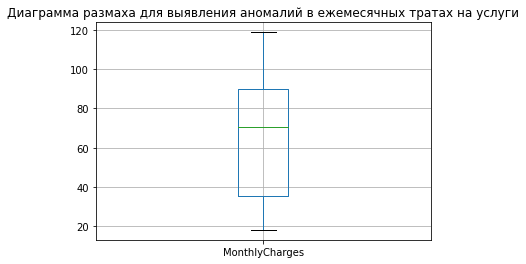

In [35]:
data.boxplot('MonthlyCharges').set_title('Диаграмма размаха для выявления аномалий в ежемесячных тратах на услуги');

In [36]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Аномалий в ежемесячных тратах на услуги не выявлено. В среднем клиенты в месяц платят по 70 долларов. Минимальный платеж клиентов в месяц составляет 18 долларов, а максимально 118.7 долларов. 

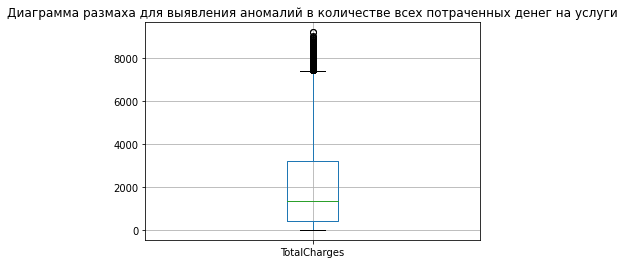

In [37]:
data.boxplot('TotalCharges').set_title('Диаграмма размаха для выявления аномалий в количестве всех потраченных денег на услуги');

In [38]:
data['TotalCharges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

Выявлены аномалии в количестве всех потраченных денег на услуги - выбросы в данных присутсвуют после значения в 7 700 долларов. Однако убирать эти данные не будем, так как это может быть категория клиентоы, которая на протяжении долгого времени обслуживалась в компании или же брала дорогие платные услуги. Более того, значения, которые отсёк верхний «ус», - редкие. Видно, насколько медиана не стремится к длинному хвосту высоких значений. 
В среднем, общее количество потраченных денег на услуги составляет 1 345 долларов, минимальное количество составляет 19 долларов, максимальное - 9 221.

### Вывод:
Мы провели полноценную предобработку данных:
* Объединили данные в единый датафрейм
* Проверили датафрейм на пропуски и обработали их
* Привели столбцы к корректному типу данных
* Выделили целевую переменную - столбец Target
* Сгенерировали допольнитейльный признак - столбец TotalDate
* Проверили датасет на аномалии и дублкаты

## 3. Исследовательский анализ данных

Исследуем на графике количество времени использования услуг клиентами

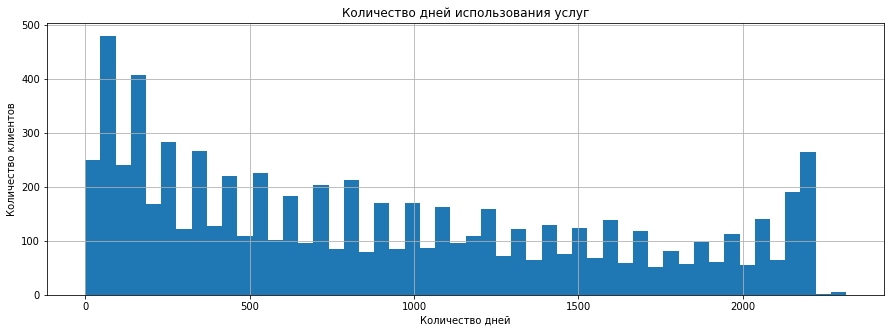

In [39]:
data['TotalDate'].hist(bins=50, figsize=(15,5)).set_title('Количество дней использования услуг')
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов');

Как мы можем наблбдать на графике, большое количество клиентов пользовались услугами компании менее 200 дней. Примерно одинаковое количество клиентов используют услуги от 250 до 2500 дней. Однако можно заметить, что подавляющее большинство клиентов пользуются услугами более 250 дней. Компании необходимо предлагать выгодные условия новым клиентам, чтобы завоевать доверие и оставить шанс получить потенциальных клиентов, а так же предлагат выгодные условия клиентам, которые пользуются услугами более полугода, чтобы иметь возможность завоевать доверие и удержать клиентов.

Посмотрим на графике дату начала пользования услугами клиентами

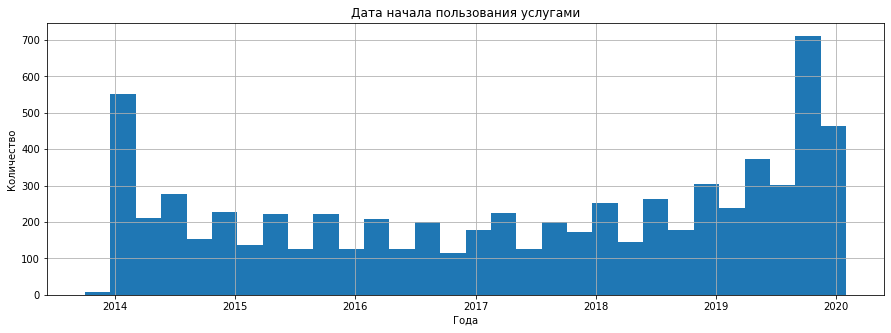

In [40]:
data['BeginDate'].hist(bins=30, figsize=(15,5)).set_title('Дата начала пользования услугами')
plt.xlabel('Года')
plt.ylabel('Количество');

Самый ранний год начала пользования услугами клиентами - 2014, с этого года компания начала существовать и мы можем заметить большой прирост клиентов, который возможно связан с тем, что когда компания выходила на рынок, то предлагала выгодные предложения для клиентов, чтобы заинтересовать их. Прирост клиентов с даты начала существования компания составил около 550 клиентов. После второй половины 2014 года наблюдается спад по количеству заключенных контрактов клиентами, однако вплоть до 2019 года показатели находятся на одном уровне - количество клиентов со второй половины 2014 года по 2019 год составляет от 120 до 300 клиентов. После второй половины 2019 года наблюдаеся резкий скачок клиентов, данный показатель больше показателя 2014 года, количество новых клиентов составило примерно 710 человек.

Изучим на графике, какой был отток клиентов по времени наблюдений

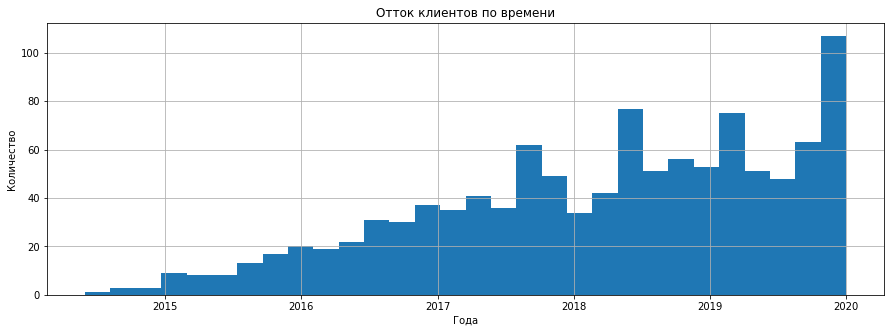

In [41]:
data.query('EndDate != "2020-02-01"')['EndDate'].hist(bins=30, figsize=(15,5)).set_title('Отток клиентов по времени')
plt.xlabel('Года')
plt.ylabel('Количество');

Как мы можем наблюдать, с начала существования компании и до 2015 года ушло менее 10 клиентов, однако после 2015 года отток клиентов начал возрастать. В периоды с 2017 года по вторую половину 2019 года количество ушедших клиентов варьировалось примерно от 40 до 80 человек. Наибольший отток клиентов пришелся на конец 2019 года - начало 2020, количество ушедших клиентов составило более 100 человек.

Изучим какой тип оплаты: ежемесячный, годовой или по два года выбирают большинство клиентов

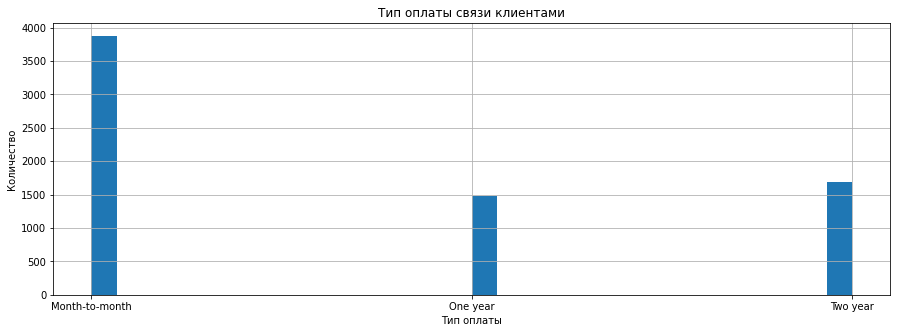

In [42]:
data['Type'].hist(bins=30, figsize=(15,5)).set_title('Тип оплаты связи клиентами')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество');

Как мы можем наблюдать, большинство клиентов выбирают ежемесячный тип оплаты.

Изучим, какой тип оплаты выбирают большинство клиентов

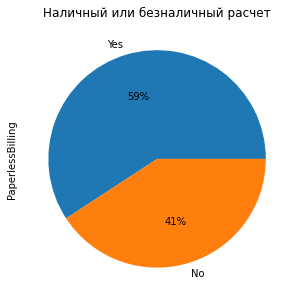

In [43]:
data['PaperlessBilling'].value_counts().plot.pie(figsize=(5, 5), autopct='%1.0f%%').set_title('Наличный или безналичный расчет');

Большинство клиентов (59%) используют безналичный расчет 

Изучим наличие супруга(и) у клиентов

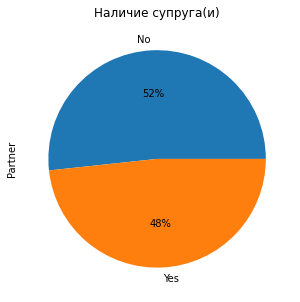

In [44]:
data['Partner'].value_counts().plot.pie(figsize=(5, 5), autopct='%1.0f%%').set_title('Наличие супруга(и)');

Как мы можем наблюдать, у чуть больше половины (52%) клиентов нет супруга(и)

Изучим наличие пенсионного статуса по возрасту у клиентов

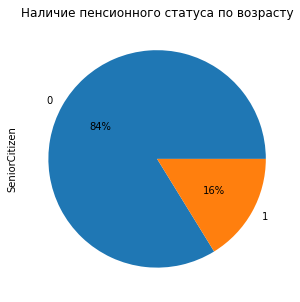

In [45]:
data['SeniorCitizen'].value_counts().plot.pie(figsize=(5, 5), autopct='%1.0f%%').set_title('Наличие пенсионного статуса по возрасту');

У 16% всех клиентов имеется пенсионный статус по возрасту

Изучим наличие иждивенцев у клиентов

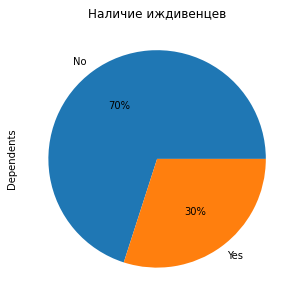

In [46]:
data['Dependents'].value_counts().plot.pie(figsize=(5, 5), autopct='%1.0f%%').set_title('Наличие иждивенцев');

Наличие иждевенцев выявлено у 30% клиентов

Проанализируем длительность пользования услугами дейсвующих и ушедших клиентов

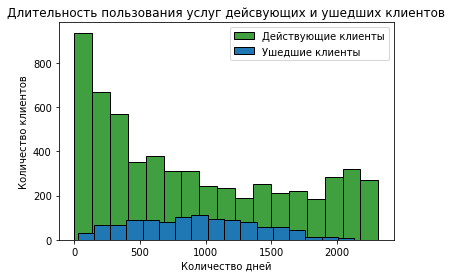

In [47]:
ax = sns.histplot(data.query('Target == 0')['TotalDate'],
                  color='g',
                  label='Действующие клиенты')
sns.histplot(data.query('Target == 1')['TotalDate'],
             ax=ax, 
             alpha=1,
             label='Ушедшие клиенты')
ax.legend()
plt.title('Длительность пользования услуг дейсвующих и ушедших клиентов')
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов');

Как мы можем наблюдать, спустя полтора года пользования услугами связи, количество действующих клиентов начинает сокращаться. Пик ухода наблюдается, когда количество дней достигает 900 (два с половиной года), после преодоления этой отметки, количество уходов начинает сокращаться и стримится к минимуму, а действующие клиенты заметно увеличиваются.

Проанализируем ежемесячные траты на услуги дейсвующих и ушедших клиентов

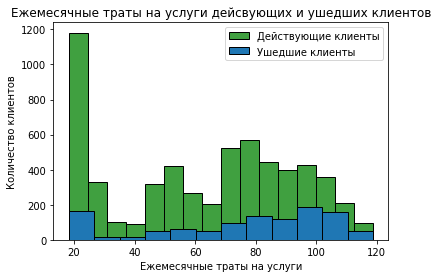

In [48]:
ax = sns.histplot(data.query('Target == 0')['MonthlyCharges'],
                  color='g',
                  label='Действующие клиенты')
sns.histplot(data.query('Target == 1')['MonthlyCharges'],
             ax=ax, 
             alpha=1,
             label='Ушедшие клиенты')
ax.legend()
plt.title('Ежемесячные траты на услуги дейсвующих и ушедших клиентов')
plt.xlabel('Ежемесячные траты на услуги')
plt.ylabel('Количество клиентов');

Как мы можем заметить, большинство ушедших клиентов пользовались дорогими тарифами. Большинство действующих клиентов, наоборот, пользуются самым дешевым тарифом. Можно предположить, что ушедших клиентов не устраивало соотношение цена-качества, в последствии чего они были вынуждены уйти.

Проанализируем наличие пенсионного статуса по возрасту дейсвующих и ушедших клиентов

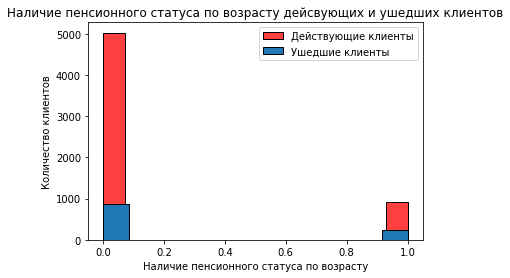

In [49]:
ax = sns.histplot(data.query('Target == 0')['SeniorCitizen'],
                  color='r',
                  label='Действующие клиенты')
sns.histplot(data.query('Target == 1')['SeniorCitizen'],
             ax=ax, 
             alpha=1,
             label='Ушедшие клиенты')
ax.legend()
plt.title('Наличие пенсионного статуса по возрасту дейсвующих и ушедших клиентов')
plt.xlabel('Наличие пенсионного статуса по возрасту')
plt.ylabel('Количество клиентов');

Клиенты, которые ушли и имеют пенсионный статус - составляют меньше половины ушедших. Так же можно заметить, что большинство действующих клиентов - не имеют пенсионный статус.

Проанализируем наличие супруга(и) у дейсвующих и ушедших клиентов

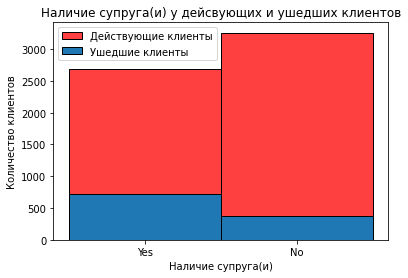

In [50]:
ax = sns.histplot(data.query('Target == 0')['Partner'],
                  color='r',
                  label='Действующие клиенты')
sns.histplot(data.query('Target == 1')['Partner'],
             ax=ax, 
             alpha=1,
             label='Ушедшие клиенты')
ax.legend()
plt.title('Наличие супруга(и) у дейсвующих и ушедших клиентов')
plt.xlabel('Наличие супруга(и)')
plt.ylabel('Количество клиентов');

Как можно заметить, у большинства ушедших клиентов имеется супруг(а), однако у большинства действующих клиентов нет супруга(и),

Проанализируем наличие иждивенцев у дейсвующих и ушедших клиентов

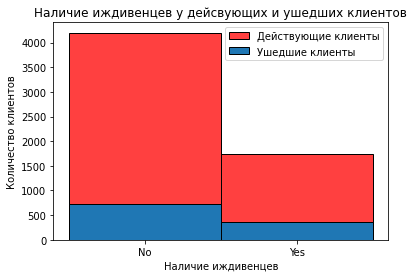

In [51]:
ax = sns.histplot(data.query('Target == 0')['Dependents'],
                  color='r',
                  label='Действующие клиенты')
sns.histplot(data.query('Target == 1')['Dependents'],
             ax=ax, 
             alpha=1,
             label='Ушедшие клиенты')
ax.legend()
plt.title('Наличие иждивенцев у дейсвующих и ушедших клиентов')
plt.xlabel('Наличие иждивенцев')
plt.ylabel('Количество клиентов');

У большинства ушедших и действующих клиентов нет иждивенцев.

Проведем анализ на корреляцию числовых признаков

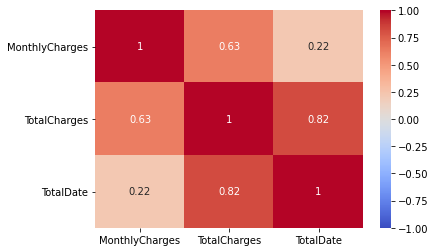

In [52]:
data_corr = data[['MonthlyCharges', 'TotalCharges', 'TotalDate']]

sns.heatmap(data_corr.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

Можем заметить тесную связь между двумя признаками: TotalCharges – всего потрачено денег на услуги и TotalDate – количество дней использования услуг - корреляция равняется 0.82, что вполне логично, так как количество потраченных денег на услуги напрямую зависит от количества дней пользованиями услугами. Так же прослеживается умеренная связь между признаком TotalCharges – всего потрачено денег на услуги и признаком MonthlyCharges – ежемесячные траты на услуги. Практически никакой связи нет уу признака MonthlyCharges – ежемесячные траты на услуги и признака TotalDate – количество дней использования услуг.

### Вывод:
Мы провели исследовательский анализ данных:
* Рассмотрели и проанализировали признаки:
    * Большое количество клиентов пользовались услугами компании менее 200 дней. Примерно одинаковое количество клиентов используют услуги от 250 до 2500 дней. Подавляющее большинство клиентов пользуются услугами более 250 дней. 
    * Прирост клиентов с даты начала существования компания составил около 550 клиентов. После второй половины 2014 года наблюдается спад по количеству заключенных контрактов клиентами, однако вплоть до 2019 года показатели находятся на одном уровне - количество клиентов со второй половины 2014 года по 2019 год составляет от 120 до 300 клиентов. После второй половины 2019 года наблюдаеся резкий скачок клиентов, данный показатель больше показателя 2014 года, количество новых клиентов составило примерно 710 человек.
    * С начала существования компании и до 2015 года ушло менее 10 клиентов, однако после 2015 года отток клиентов начал возрастать. В периоды с 2017 года по вторую половину 2019 года количество ушедших клиентов варьировалось примерно от 40 до 80 человек. Наибольший отток клиентов пришелся на конец 2019 года - начало 2020, количество ушедших клиентов составило более 100 человек.
    * Большинство клиентов выбирают ежемесячный тип оплаты.
    * Большинство клиентов (59%) используют безналичный расчет 
    * Как мы можем наблюдать, у чуть больше половины (52%) клиентов нет супруга(и)
    * У 16% всех клиентов имеется пенсионный статус по возрасту
    * Наличие иждевенцев выявлено у 30% клиентов
* Проанализировали ушедщих и действующих клиентов:       
    * Спустя полтора года пользования услугами связи, количество действующих клиентов начинает сокращаться. Пик ухода наблюдается, когда количество дней достигает 900 (два с половиной года), после преодоления этой отметки, количество уходов начинает сокращаться и стримится к минимуму, а действующие клиенты заметно увеличиваются
    * Большинство ушедших клиентов пользовались дорогими тарифами. Большинство действующих клиентов, наоборот, пользуются самым дешевым тарифом
    * Клиенты, которые ушли и имеют пенсионный статус - составляют меньше половины ушедших. Большинство действующих клиентов - не имеют пенсионный статус
    * У большинства ушедших клиентов имеется супруг(а), однако у большинства действующих клиентов нет супруга(и)
    * У большинства ушедших и действующих клиентов нет иждивенцев
    
* Провели анализ на корреляцию числовых признаков: 
    * Тесную связь между двумя признаками: TotalCharges – всего потрачено денег на услуги и TotalDate – количество дней использования услуг - корреляция равняется 0.82, что вполне логично, так как количество потраченных денег на услуги напрямую зависит от количества дней пользованиями услугами. Так же прослеживается умеренная связь между признаком TotalCharges – всего потрачено денег на услуги и признаком MonthlyCharges – ежемесячные траты на услуги. Практически никакой связи нет уу признака MonthlyCharges – ежемесячные траты на услуги и признака TotalDate – количество дней использования услуг.

## 4. Подготовка данных

Удалим неинформативные признаки

In [53]:
data = data.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

In [54]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,TotalDate
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Зафиксируем параметр RANDOM_STATE = 250923

In [55]:
SEED = 250923

Объявим две переменные

In [56]:
features = data.drop(['Target'], axis=1)
target = data['Target']

Разобъем на выборки для моделей бустинга

In [57]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.25, random_state=SEED, stratify=target)

Разобъем на выборки для модели случайного леса

In [58]:
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features, target, 
                                                                    test_size=0.25, random_state=SEED, stratify=target)

Проверяем размер выборок

In [59]:
print('Размер обучающей выборки:')
print(features_train.shape)
print(target_train.shape)

print('Размер тестовой выборки:')
print(features_test.shape)
print(target_test.shape)

Размер обучающей выборки:
(5282, 18)
(5282,)
Размер тестовой выборки:
(1761, 18)
(1761,)


In [60]:
print('Размер обучающей выборки:')
print(x_train_ohe.shape)
print(y_train_ohe.shape)

print('Размер тестовой выборки:')
print(x_test_ohe.shape)
print(y_test_ohe.shape)

Размер обучающей выборки:
(5282, 18)
(5282,)
Размер тестовой выборки:
(1761, 18)
(1761,)


In [61]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,TotalDate
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [63]:
numeric = ['MonthlyCharges', 'TotalCharges', 'TotalDate', 'SeniorCitizen', 'Target']

In [91]:
numeric = ['MonthlyCharges', 'TotalCharges', 'TotalDate']
cat_columns = data.drop(['MonthlyCharges', 'TotalCharges', 'TotalDate', 'Target'], axis = 1).columns

ohe = OneHotEncoder(drop='first')
ohe.fit(x_train_ohe[cat_columns])

new_columns = ohe.get_feature_names(cat_columns)

features_train_ohe = pd.DataFrame(
    ohe.transform(x_train_ohe[cat_columns]).toarray(), columns = new_columns, index = x_train_ohe.index
)

features_train_ohe = features_train_ohe.join(x_train_ohe[numeric])

In [77]:
data['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [78]:
data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [79]:
data['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

Используем OneHotEncoder для кодирования категориальных признаков

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


Убираем "проклятье размерности"

In [81]:
!pip install category_encoders
from category_encoders.m_estimate import MEstimateEncoder

mee_encoder = MEstimateEncoder(cols=['Type'], 
                               handle_unknown='value', 
                               handle_missing = 'value').fit(x_train_ohe, y_train_ohe) 

mee_enc_ohe_x_train = mee_encoder.transform(x_train_ohe)
mee_enc_ohe_x_test = mee_encoder.transform(x_test_ohe)

ohe = OneHotEncoder(drop='first', sparse=False)    

X_train_encoded_ohe = ohe.fit_transform(mee_enc_ohe_x_train.select_dtypes(include='object'))
X_test_encoded_ohe = ohe.transform(mee_enc_ohe_x_test.select_dtypes(include='object'))

#Для каждой из выборок объединяем закодированные данные
x_train_final_ohe = np.concatenate([X_train_encoded_ohe, 
                                    x_train_ohe.select_dtypes(include='int64')], axis=1)

x_test_final_ohe = np.concatenate([X_test_encoded_ohe, 
                                    x_test_ohe.select_dtypes(include='int64')], axis=1)

     |████████████████████████████████| 81 kB 791 kB/s eta 0:00:011


In [82]:
print('Размер обучающей выборки:')
print(x_train_final_ohe.shape)
print(y_train_ohe.shape)

print('Размер тестовой выборки:')
print(x_test_final_ohe.shape)
print(y_test_ohe.shape)

Размер обучающей выборки:
(5282, 18)
(5282,)
Размер тестовой выборки:
(1761, 18)
(1761,)


### Вывод:
Мы произвели подготовку данных:
* Выполнили деление данных на выборки
* Выполнили кодировку данных, где это необходимо

## 5. Обучение моделей   

Проверяем датасет на сбалансированность классов

0    0.843675
1    0.156325
Name: Target, dtype: float64


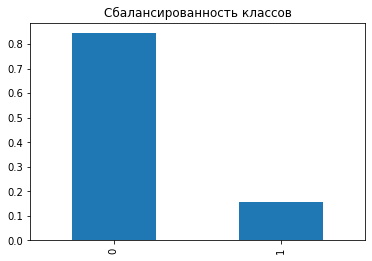

In [62]:
class_frequency = data['Target'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar').set_title('Сбалансированность классов');

Модель случайного леса

In [88]:
%%time
model_rfc = RandomForestClassifier(random_state=SEED, class_weight='balanced')
parametrs_1 = {
    'n_estimators': [1, 30, 5],
    'max_depth': [1, 11],
    'min_samples_split': [2, 20, 2],
    'min_samples_leaf': [1, 20, 2]
}
scores_rfc = GridSearchCV(model_rfc,
                          parametrs_1,
                          scoring='roc_auc',
                          cv=5)

scores_rfc.fit(x_train_final_ohe, y_train_ohe)
best_score_rfc = round(scores_rfc.best_score_, 2)

print('Лучшие параметры:', scores_rfc.best_params_)
print('Лучшее значение AUC-ROC на тренировочной выборке:', best_score_rfc)

Лучшие параметры: {'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 30}
Лучшее значение AUC-ROC на тренировочной выборке: 0.8
CPU times: user 9.21 s, sys: 47.2 ms, total: 9.26 s
Wall time: 9.27 s


Лучшее значение AUC-ROC на тренировочной выборке модели случайного леса составляет 0.80 при гиперпараметрах max_depth: 11, min_samples_leaf: 20, min_samples_split: 2, n_estimators: 30

Модель градиентного бустинга: CatBoost

In [89]:
%%time
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

model_cat = CatBoostClassifier(random_state=SEED, verbose=0, auto_class_weights='Balanced')

parametrs_2 = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 200, 10]
}

scores_cat = GridSearchCV(model_cat,
                          parametrs_2,
                          scoring='roc_auc',
                          cv=5)

scores_cat.fit(features_train, target_train, cat_features=cat_features)
best_score_cat= round(scores_cat.best_score_, 2)

print('Лучшие параметры:', scores_cat.best_params_)
print('Лучшее значение AUC-ROC на тренировочной выборке:', best_score_cat)

Лучшие параметры: {'iterations': 200, 'learning_rate': 0.3}
Лучшее значение AUC-ROC на тренировочной выборке: 0.9
CPU times: user 17.4 s, sys: 644 ms, total: 18.1 s
Wall time: 55.8 s


Лучшее значение AUC-ROC на тренировочной выборке модели градиентного бустинга CatBoost составляет 0.90 при гиперпараметрах iterations: 200, learning_rate: 0.3

Модель градиентного бустинга: LightGBM

In [ ]:
%%time
model_lgbmr = LGBMClassifier(class_weight='balanced') 
parametrs_3 = {'num_leaves':[25, 50, 5], 
              'max_depth':[1, 10, 2], 
              'random_state':[250923]
             }

scores_lgbmr = GridSearchCV(model_lgbmr,
                          parametrs_3,
                          scoring='roc_auc',
                          cv=5)

scores_lgbmr.fit(x_train_final_ohe, y_train_ohe)
best_score_lgbmr = round(scores_lgbmr.best_score_, 2)

print('Лучшие параметры:', scores_lgbmr.best_params_)
print('Лучшее значение AUC-ROC на тренировочной выборке:', best_score_lgbmr)

Лучшее значение AUC-ROC на тренировочной выборке модели градиентного бустинга LightGBM составляет 0.88 при гиперпараметрах max_depth: 10, num_leaves: 25

Наилучшей моделью оказалась модель градиентного бустинга: CatBoost с показателем 0.91 метрики AUC-ROC.

### Вывод:
Мы обучили различные модели машинного обучения:
* Провели настройки моделей, учитывая дисбаланс классов:
    * Лучшее значение AUC-ROC на тренировочной выборке модели случайного леса составляет 0.80 
    * Значение AUC-ROC на тренировочной выборке модели градиентного бустинга CatBoost составляет 0.90 
    * Значение AUC-ROC на тренировочной выборке модели градиентного бустинга LightGBM составляет 0.88
* Выбрали наилучшую модель:
    * Наилучшей моделью оказалась модель градиентного бустинга: CatBoost с показателем 0.90 метрики AUC-ROC

## 6. Тестирование наилучшей модели

Проверяем наилучшую модель градиентного бустинга CatBoost на тестовой выборке

In [90]:
%%time
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

model = CatBoostClassifier(random_state=SEED, verbose=0, learning_rate=0.3, iterations=200, auto_class_weights='Balanced')

model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('Лучшее значение AUC-ROC на тестовой выборке:', roc_auc_score(target_test, probabilities_one_test))

0:	learn: 0.6084010	total: 8.38ms	remaining: 1.67s
10:	learn: 0.4780297	total: 73.4ms	remaining: 1.26s
20:	learn: 0.4485263	total: 136ms	remaining: 1.16s
30:	learn: 0.4250957	total: 201ms	remaining: 1.09s
40:	learn: 0.3863257	total: 274ms	remaining: 1.06s
50:	learn: 0.3426813	total: 353ms	remaining: 1.03s
60:	learn: 0.3175300	total: 425ms	remaining: 969ms
70:	learn: 0.2796565	total: 504ms	remaining: 916ms
80:	learn: 0.2511768	total: 598ms	remaining: 879ms
90:	learn: 0.2349261	total: 679ms	remaining: 813ms
100:	learn: 0.2158388	total: 757ms	remaining: 742ms
110:	learn: 0.1999100	total: 839ms	remaining: 673ms
120:	learn: 0.1842725	total: 916ms	remaining: 598ms
130:	learn: 0.1706230	total: 994ms	remaining: 523ms
140:	learn: 0.1604167	total: 1.07s	remaining: 448ms
150:	learn: 0.1482040	total: 1.16s	remaining: 376ms
160:	learn: 0.1394579	total: 1.24s	remaining: 301ms
170:	learn: 0.1294656	total: 1.33s	remaining: 225ms
180:	learn: 0.1225503	total: 1.4s	remaining: 147ms
190:	learn: 0.1152036	

Построим график ROC-кривой на тестовой выборке

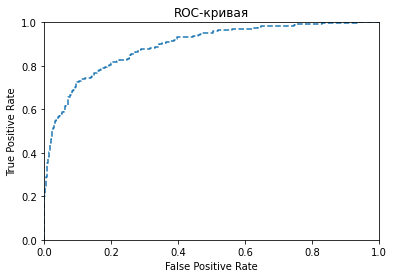

In [91]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

Наилучшая модель градиентного бустинга CatBoost показала значение метрики AUC-ROC на тестовой выборке 0.89

### Вывод:
* Мы провели тестирование наилучшей моедли - модели градиентного бустинга CatBoost:
     * Наилучшая модель градиентного бустинга CatBoost показала значение метрики AUC-ROC на тестовой выборке 0.89
     * Мы добились, чтобы качество финальной модели превышало значение основной метрики: AUC-ROC >= 0.85

## 7. Общий вывод

1. Мы познакомились с первоначальными данными
2. Данные разделены на четыре датасета:
    * Информация о договоре - 7043 записи и 8 столбцов, ежемесячные траты на услуги в среднем составляют 70.3 
    * Персональные данные клиента - 7043 записи и 5 столбцов
    * Информация об интернет-услугах - 5517 записи и 8 столбцов
    * Информация об услугах телефонии - 6361 записи и 2 столбца
3. Целевым признаком является:
    * EndDate — дата окончания пользования услугами   
4. Мы провели полноценную предобработку данных:
    * Объединили данные в единый датафрейм
    * Проверили датафрейм на пропуски и обработали их
    * Привели столбцы к корректному типу данных
    * Выделили целевую переменную - столбец Target
    * Сгенерировали допольнитейльный признак - столбец TotalDate
    * Проверили датасет на аномалии и дублкаты  
5. Мы провели исследовательский анализ данных
6. Рассмотрели и проанализировали признаки:
    * Большое количество клиентов пользовались услугами компании менее 200 дней. Примерно одинаковое количество клиентов используют услуги от 250 до 2500 дней. Подавляющее большинство клиентов пользуются услугами более 250 дней. 
    * Прирост клиентов с даты начала существования компания составил около 550 клиентов. После второй половины 2014 года наблюдается спад по количеству заключенных контрактов клиентами, однако вплоть до 2019 года показатели находятся на одном уровне - количество клиентов со второй половины 2014 года по 2019 год составляет от 120 до 300 клиентов. После второй половины 2019 года наблюдаеся резкий скачок клиентов, данный показатель больше показателя 2014 года, количество новых клиентов составило примерно 710 человек.
    * С начала существования компании и до 2015 года ушло менее 10 клиентов, однако после 2015 года отток клиентов начал возрастать. В периоды с 2017 года по вторую половину 2019 года количество ушедших клиентов варьировалось примерно от 40 до 80 человек. Наибольший отток клиентов пришелся на конец 2019 года - начало 2020, количество ушедших клиентов составило более 100 человек.
    * Большинство клиентов выбирают ежемесячный тип оплаты.
    * Большинство клиентов (59%) используют безналичный расчет 
    * Как мы можем наблюдать, у чуть больше половины (52%) клиентов нет супруга(и)
    * У 16% всех клиентов имеется пенсионный статус по возрасту
    * Наличие иждевенцев выявлено у 30% клиентов
7. Проанализировали ушедщих и действующих клиентов:       
    * Спустя полтора года пользования услугами связи, количество действующих клиентов начинает сокращаться. Пик ухода наблюдается, когда количество дней достигает 900 (два с половиной года), после преодоления этой отметки, количество уходов начинает сокращаться и стримится к минимуму, а действующие клиенты заметно увеличиваются
    * Большинство ушедших клиентов пользовались дорогими тарифами. Большинство действующих клиентов, наоборот, пользуются самым дешевым тарифом
    * Клиенты, которые ушли и имеют пенсионный статус - составляют меньше половины ушедших. Большинство действующих клиентов - не имеют пенсионный статус
    * У большинства ушедших клиентов имеется супруг(а), однако у большинства действующих клиентов нет супруга(и)
    * У большинства ушедших и действующих клиентов нет иждивенцев    
    
8. Провели анализ на корреляцию числовых признаков: 
    * Тесную связь между двумя признаками: TotalCharges – всего потрачено денег на услуги и TotalDate – количество дней использования услуг - корреляция равняется 0.82, что вполне логично, так как количество потраченных денег на услуги напрямую зависит от количества дней пользованиями услугами. Так же прослеживается умеренная связь между признаком TotalCharges – всего потрачено денег на услуги и признаком MonthlyCharges – ежемесячные траты на услуги. Практически никакой связи нет уу признака MonthlyCharges – ежемесячные траты на услуги и признака TotalDate – количество дней использования услуг.
    
9. Мы произвели подготовку данных:
    * Выполнили деление данных на выборки
    * Выполнили кодировку данных, где это необходимо  
10. Мы обучили различные модели машинного обучения:\
11. Провели настройки моделей, учитывая дисбаланс классов:
    * Лучшее значение AUC-ROC на тренировочной выборке модели случайного леса составляет 0.80 
    * Значение AUC-ROC на тренировочной выборке модели градиентного бустинга CatBoost составляет 0.90 
    * Значение AUC-ROC на тренировочной выборке модели градиентного бустинга LightGBM составляет 0.88
12. Выбрали наилучшую модель:
    * Наилучшей моделью оказалась модель градиентного бустинга: CatBoost с показателем 0.90 метрики AUC-ROC     
13. Мы провели тестирование наилучшей моедли - модели градиентного бустинга CatBoost:
     * Наилучшая модель градиентного бустинга CatBoost показала значение метрики AUC-ROC на тестовой выборке 0.89
     * Мы добились, чтобы качество финальной модели превышало значение основной метрики: AUC-ROC >= 0.85
     
     
Рекомендации:  
Мы построили отличную модель для прогнозирования оттока клиентов. С нашей моделью оператор связи «Ниединогоразрыва.ком» не только будет предсказывать, но и предотвращать уход клиента. Теперь компания может своевременно предлагать таким клиентам специальные предложения и условия, тем самым сохраняя клиентсткую базу и приобретая больше лояльных клиентов. С таким внимательным подходом к клиентам, компания расширит клиентскую базу и приумножит свои доходы.

## 8. Отчет о проделанной работе

- В данном проекте мы придерживались основного плана, однако в исследовательском анализе данных не было выполнено выдвижение гипотез, а в разделе "подготовка данных" не были масштабированны данные, так как это нам не потребовалось, все остальные шаги плана были выполнены. 
- Трудности в работе не возникли. Под ключевыми этапами можно выделить все этапы в проекте, так как все этапы важны, начиная от плана работы и заканчивая ее отчетом.
- Предобработка данных происходила в несколько этапов: 
    * Объединение данных  в одну таблицу
    * Выявление пропусков в стобцах InternetServiceб, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines и их устранение
    * Проверка данных на дубликаты
    * Привели столбцы BeginDate, EndDate и TotalCharges к корректному типу данных
    * Выделение целевой переменной - столбец Target
    * Генерация нового признака: какое количество времени клиенты пользовались услугами - столбец TotalDate
    * Проверка столбцов MonthlyCharges и TotalCharges на аномалии
- a) Признаки, которые использовались при обучении модели: 
    * Type - тип оплаты: ежемесячный, годовой и тд
    * PaperlessBilling - безналичный расчет	
    * PaymentMethod - способ оплаты	
    * MonthlyCharges - ежемесячные траты на услуги
    * TotalCharges - всего потрачено денег на услуги	
    * gender - пол клиента
    * SeniorCitizen - наличие пенсионного статуса по возрасту
    * Partner - наличие супруга(и)	
    * Dependents - наличие иждивенцев	
    * InternetService	- Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic)
    * OnlineSecurity - интернет-безопасность: блокировка небезопасных сайтов 
    * OnlineBackup - облачное хранилище файлов для резервного копирования данных	
    * DeviceProtection - интернет-безопасность: антивирус 	
    * TechSupport - выделенная линия технической поддержки 	
    * StreamingTV - стриминговое телевидение	
    * StreamingMovies	- каталог фильмов
    * MultipleLines - наличие возможности ведения параллельных линий во время звонка
- b) Признаки, которые были сгенерированы и были использованы при обучении:
    * Target - целевая переменная (ушел/не ушел клиент)
    * TotalDate - какое количество времени клиенты пользовались услугами
- c) Неинформативные признаки, которые были удалены до обучения модели:
    * BeginDate - дата начала пользования услугами
    * EndDate - дата окончания пользования услугами
    * customerID - уникальный ID клиента

- Размер тестовой выборки у нас составил: test_size = 0.25, параметр RANDOM_STATE = 250923.

- Наилучшей моделью оказалась модель градиентного спуска, разработка Яндекса -  **CatBoost** при параметрах:
    * **random_state(генератор псевдослучайных чисел)=250923**, 
    * **verbose(подробный вывод)=0**, 
    * **learning_rate(скорость обучения)=0.3**, 
    * **iterations(количесиво итераций)=200**, 
    * **auto_class_weights(балансировка классов внутри модели)='Balanced'**
    * **Значение метрики AUC-ROC на тестовой выборке составило  0.89**

- Я уверена, что высокое значение метрики ROC-AUC помогли достичь несколько аспектов:
    * Правильная и хорошая предобработка данных
    * Пыявление нужных признаков и устранение неинформативных признаков для обучения модели
    * Так же, что в самой модели CatBoost производилась кодировка данных
    * Кроме того, на отличный результат модели повлияли подобранные гиперпараметры
